<h1><center><font size="6">Predicting Financial Distress</font></center></h1>

<h2><center><font size="4"> Kaggle </font></center></h2>

In [1]:
# The hyperparam only does the grid search but with precision_at_recall_threshold measure. The resampling is done outside

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)
1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate Reduce Memory](#3)

1. [Hyperparameter Tuning](#4)
    1. [Data Prep](#41)
        1. [Memory Footprint Reduction](#411)
        1. [Data Splitting](#412)
    1. [Search Algorithms - GridSearchCV](#42)

1. [Test Performance](#5)
    1. [Modelling Workflow](#51)
    
1. [Export Data, Pickled Model and Tuned Params](#6)

1. [References](#7)

## <a id='1'>Introduction</a>  
We will use the raw data to perform hyperparameter tuning on the Random Forest model after resampling

## <a id='2'>Initialization</a>  

### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os

import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") 
# Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [2]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'SeriousDlqin2yrs'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['No Distress', 'Distress']

input_file_name = 'cs-training.csv'

intermediate_data_path = '../intermediate data/'

# This will be used to compare resampling techniques
clean_df_file_name = intermediate_data_path + 'day2_cleaned_df_output_20200515.csv'

tuned_model_params_name = 'day4_grid_search_rf_params_'
tuned_model_name = 'day4_rf_on_engineered_df_'

# Enter the date in which this notebook is run
export_date = '20200515'

In [3]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
import os
print(os.listdir('../intermediate data'))
# This will list all the files in this folder

['.ipynb_checkpoints', 'Archive', 'day1_cleaned_df_output_20200511.pkl', 'day2_cleaned_df_output_20200515.csv']


## <a id='3'>Load Data & Validate</a>  

In [4]:
clean_df = pd.read_csv(clean_df_file_name)
clean_df.sample(5)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
36220,0.082587,69.0,0.0,0.132496,1750.000000,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0
15037,0.350255,60.0,0.0,655.000000,3953.264725,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0
7120,0.654997,44.0,0.0,0.502722,9000.000000,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0
42362,0.618248,39.0,0.0,0.086845,7000.000000,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0
22994,0.204443,72.0,0.0,0.346552,6757.000000,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0


Lets check the head & tail to make sure there is nothing going on

In [5]:
clean_df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
0,0.000000,29.0,0.0,0.011513,4342.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.595526,55.0,0.0,0.835333,1833.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.000000,43.0,0.0,0.043437,4166.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0


In [6]:
clean_df.tail(3)
# similar logic here

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
149997,0.967086,35.0,0.0,0.469314,3600.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0
149998,0.013522,62.0,0.0,0.257847,10098.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0
149999,0.035787,33.0,0.0,0.185247,17500.0,12.0,0.0,2.0,0.0,2.0,0.0,0.0,0


No data corruption seen in either the head or the tail

In [7]:
# Lets see the data structure
clean_df.info()
# They all seem to have been correctly read 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 1   age                                   150000 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  float64
 3   DebtRatio                             150000 non-null  float64
 4   MonthlyIncome                         150000 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       150000 non-null  float64
 6   NumberOfTimes90DaysLate               150000 non-null  float64
 7   NumberRealEstateLoansOrLines          150000 non-null  float64
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  float64
 9   NumberOfDependents                    150000 non-null  float64
 10  MonthlyIncome_na                      150000 non-null  float64
 11  

All good to proceed

## <a id='4'>Hyperparam Tuning</a>  

### <a id='41'>Data Prep

#### <a id='411'>Memory Footprint Reduction

In [8]:
from helper_functions_comprehensive import reduce_mem_usage_function
clean_df, NAlist = reduce_mem_usage_function(clean_df)

# Always reduce the dataset right after loading 
#even if you are sure that when exporting it you have reduced it
# This is because Pandas inflates the size of the data

Memory usage of dataframe is 14.88 MB
Column RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column age dtype after is uint8 
******************************
Column NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column DebtRatio dtype after is float32 
******************************
Column MonthlyIncome dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents dtype after is float32 
******************************
Column MonthlyIncome_na dtype after is float32 
******************************
Column NumberOfDepende

In [9]:
# Get the age column converted into float32
clean_df['age'] = clean_df['age'].astype('float32')


In [10]:
clean_df.dtypes

RevolvingUtilizationOfUnsecuredLines    float32
age                                     float32
NumberOfTime30-59DaysPastDueNotWorse    float32
DebtRatio                               float32
MonthlyIncome                           float32
NumberOfOpenCreditLinesAndLoans         float32
NumberOfTimes90DaysLate                 float32
NumberRealEstateLoansOrLines            float32
NumberOfTime60-89DaysPastDueNotWorse    float32
NumberOfDependents                      float32
MonthlyIncome_na                        float32
NumberOfDependents_na                   float32
SeriousDlqin2yrs                        float32
dtype: object

#### <a id='412'>Data Splitting

#### Feature - Target split

In [11]:
X = clean_df.drop(target_class_name, axis=1)
y = clean_df[target_class_name]

##### Train - Test Split

In [12]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print('Length of (train): {} | positives in y (train): {}'.format(len(X_train), sum(y_train)))
print('Length of (test): {} | positives in y (test): {}'.format(len(X_test), sum(y_test)))

Length of (train): 120000 | positives in y (train): 8021.0
Length of (test): 30000 | positives in y (test): 2005.0


### <a id='42'>Search Algorithms - GridSearchCV

Q Why do you need to pass in your custom scoring function instead of the default?
Because grid search uses accuracy by default which we know ahead of time that its not the right metric for imbalanced datasets

https://stackoverflow.com/questions/32889929/gridsearchcv-scoring-parameter-using-scoring-f1-or-scoring-none-by-default-u

You have the option to select one of these built in scoring functions

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://www.kaggle.com/c/expedia-hotel-recommendations/discussion/21154

#### Import relevant libraries

In [13]:
from helper_functions_comprehensive import metrics_store_function, tune_grid_search_function

from sklearn.ensemble import RandomForestClassifier
# from collections import Counter

# This is for the hyperparam tuning and KFold CV
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# Classification metrics
from sklearn.metrics import precision_score, recall_score, f1_score, \
                        roc_auc_score, average_precision_score, fbeta_score

#### Upsample train fold

In [14]:
# Keep a holdout set that has not been sampled
cv_fold_X_train, cv_fold_X_val, cv_fold_y_train, cv_fold_y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42, stratify=y_train)

# Generate the resampled data using one of the imblearn methods selected in Day2
from imblearn.combine import SMOTEENN

# Upsample the train fold only before passing it on 
X_train_resampled, y_train_resampled = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)

#### Check out extent of overfitting

In [15]:
# from sklearn.model_selection import learning_curve, ShuffleSplit
# from helper_functions_comprehensive import plot_learning_curve

# title = "Learning Curves (Random Forest Classifier)"
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)

# estimator = RandomForestClassifier(random_state=42)
# plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, 
#                     ylim=(0.9, 1.05), cv=cv, n_jobs=4)
# # This seems to be overfitting given the huge gap in train and test performance

In [16]:
# title = "Learning Curves (Random Forest Classifier)"
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# param_combo_dict = {'max_depth':10, 'min_samples_split':10, 'min_samples_leaf': 5}
# estimator = RandomForestClassifier(random_state=42, **param_combo_dict)
# plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.75, 1.05), cv=cv, n_jobs=4)

# # You can see that constraining some of the parameters reduces overfitting at the cost of accuracy

In [17]:
# HW: The audience is encouraged to figure out the extent of overfitting

#### Initialize the search space

In [18]:
# Higher Number of decision trees used in the ensemble will increase the accuracy
n_estimators = [50, 100, 200, 400]

# Increasing number of levels in tree may cause overfitting
max_depth = [5, 6, 7, 8, 9, 10, 12, 14, 16]

# Higher number of samples required to split a node will reduce overfitting
min_samples_split = [5, 10, 20, 50]

# Higher number of samples required at each leaf node will also reduce overfitting
min_samples_leaf = [2, 5, 10, 20]

# Create the grid for the random search. 
rf_params = {'n_estimators': n_estimators,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}

#### Tune the classifier

In [19]:
from helper_functions_comprehensive import precision_at_recall_threshold_function

In [ ]:
# I had to change the n_jobs = 1 instead of -1 because I was getting an error
# ValueError: buffer source array is read-only
# which is a bug in the Pandas compatibility with Cython (and remained so despite updating to 1.0.3)

In [20]:
%%time
# For now, we will be keeping the same classifier as what was used in the previous weeks
classifier_type = RandomForestClassifier

hyperparam_results = tune_grid_search_function(X_train_resampled, y_train_resampled, 
cv_fold_X_val, cv_fold_y_val, rf_params, classifier_type = classifier_type, is_custom_scorer = True, 
        custom_scoring_function =  precision_at_recall_threshold_function, recall_threshold=0.85)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.913, total=   4.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.950, total=   3.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.962, total=   3.8s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.919, total=   7.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   19.6s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.956, total=   7.9s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.5s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.958, total=   7.7s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   35.2s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.921, total=  15.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   50.8s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.951, total=  15.5s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.961, total=  15.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.920, total=  31.6s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.953, total=  30.8s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.958, total=  30.3s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.915, total=   4.1s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.951, total=   4.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.954,

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.914, total=  15.8s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.949, total=  15.7s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.963, total=  15.3s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400, score=0.920, total=  31.9s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400, score=0.954, total=  31.2s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=400, score=0.956,

[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.922, total=   8.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.952, total=   7.8s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.960, total=   7.8s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200, score=0.916, total=  16.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200, score=0.953, total=  15.3s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=200, s

[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.925, total=   3.9s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.946, total=   4.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.961, total=   3.9s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100, score=0.919, total=   8.1s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100, score=0.954, total=   7.8s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=5, n_estimators=100, score=

[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.919, total=  31.6s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.954, total=  30.3s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.955, total=  31.1s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.927, total=   4.5s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.970, total=   4.4s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.

[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.927, total=  17.8s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.970, total=  17.3s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.970, total=  17.4s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=400, score=0.929, total=  35.5s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=400, score=0.967, total=  34.2s
[CV] max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=2, min_samples_split=50, n_estimators=400, s

[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.926, total=   9.0s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.964, total=   8.7s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.967, total=   8.8s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=200, score=0.927, total=  17.8s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=200, score=0.965, total=  17.5s
[CV] max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=200 
[CV]  max_depth=6, min_samples_leaf=5, min_samples_split=50, n_estimators=200, s

[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.929, total=   4.4s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.967, total=   4.4s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.962, total=   4.4s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.926, total=   8.9s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.963, total=   8.6s
[CV] max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=6, min_samples_leaf=10, min_samples_split=50, n_estimators=

[CV]  max_depth=6, min_samples_leaf=20, min_samples_split=20, n_estimators=400, score=0.929, total=  36.1s
[CV] max_depth=6, min_samples_leaf=20, min_samples_split=20, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=20, min_samples_split=20, n_estimators=400, score=0.965, total=  34.4s
[CV] max_depth=6, min_samples_leaf=20, min_samples_split=20, n_estimators=400 
[CV]  max_depth=6, min_samples_leaf=20, min_samples_split=20, n_estimators=400, score=0.972, total=  35.0s
[CV] max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.927, total=   4.5s
[CV] max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=50, score=0.967, total=   4.4s
[CV] max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=6, min_samples_leaf=20, min_samples_split=50, n_estimators=

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=200, score=0.935, total=  19.6s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=200, score=0.976, total=  19.2s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=200, score=0.978, total=  19.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=400 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=400, score=0.935, total=  39.6s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=400 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=400, score=0.976, total=  38.7s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=400 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=20, n_estimators=400, s

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=100, score=0.938, total=   9.9s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=100, score=0.974, total=   9.6s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=100, score=0.980, total=   9.6s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=200 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=200, score=0.937, total=  19.5s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=200 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=200, score=0.977, total=  19.1s
[CV] max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=200 
[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=20, n_estimators=200, s

[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.938, total=   4.9s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.975, total=   4.8s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=50, score=0.976, total=   4.8s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, score=0.937, total=   9.9s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100, score=0.975, total=   9.8s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=100 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=20, n_estimators=

[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=10, n_estimators=400, score=0.935, total=  38.9s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=10, n_estimators=400 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=10, n_estimators=400, score=0.975, total=  38.4s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=10, n_estimators=400 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=10, n_estimators=400, score=0.978, total=  38.3s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=20, n_estimators=50 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=20, n_estimators=50, score=0.939, total=   5.1s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=20, n_estimators=50 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=20, n_estimators=50, score=0.974, total=   4.8s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=20, n_estimators=50 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=20, n_estimators=

[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=0.948, total=  21.3s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=0.981, total=  21.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200, score=0.983, total=  21.1s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=0.945, total=  42.5s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=400, score=0.982, total=  41.8s
[CV] max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=400, s

[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, score=0.946, total=  10.6s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, score=0.981, total=  10.5s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=100, score=0.982, total=  10.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.945, total=  21.3s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.981, total=  21.0s
[CV] max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200, s

[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.946, total=   5.3s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.980, total=   5.2s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=50, score=0.983, total=   5.3s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, score=0.945, total=  10.8s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100, score=0.982, total=  10.4s
[CV] max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=

[CV]  max_depth=8, min_samples_leaf=20, min_samples_split=5, n_estimators=400, score=0.946, total=  42.4s
[CV] max_depth=8, min_samples_leaf=20, min_samples_split=5, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=20, min_samples_split=5, n_estimators=400, score=0.982, total=  41.5s
[CV] max_depth=8, min_samples_leaf=20, min_samples_split=5, n_estimators=400 
[CV]  max_depth=8, min_samples_leaf=20, min_samples_split=5, n_estimators=400, score=0.982, total=  41.8s
[CV] max_depth=8, min_samples_leaf=20, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=20, min_samples_split=10, n_estimators=50, score=0.948, total=   5.3s
[CV] max_depth=8, min_samples_leaf=20, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=20, min_samples_split=10, n_estimators=50, score=0.978, total=   5.3s
[CV] max_depth=8, min_samples_leaf=20, min_samples_split=10, n_estimators=50 
[CV]  max_depth=8, min_samples_leaf=20, min_samples_split=10, n_estimators=50, s

[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.954, total=  22.5s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.987, total=  22.2s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=200, score=0.988, total=  22.0s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.955, total=  45.1s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.987, total=  44.7s
[CV] max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.988,

[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=100, score=0.956, total=  11.3s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=100, score=0.986, total=  11.3s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=100, score=0.989, total=  11.1s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.954, total=  22.8s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.987, total=  22.4s
[CV] max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.989,

[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.953, total=   5.6s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.987, total=   5.4s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=50, score=0.988, total=   5.5s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.953, total=  11.6s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.986, total=  11.0s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=

[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=50, n_estimators=400, score=0.954, total=  45.6s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=50, n_estimators=400, score=0.986, total=  44.4s
[CV] max_depth=9, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=10, min_samples_split=50, n_estimators=400, score=0.987, total=  44.4s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.954, total=   5.6s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.987, total=   5.5s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=5, n_estimators=50, sc

[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=200, score=0.954, total=  22.6s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=200, score=0.987, total=  22.1s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=200 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=200, score=0.987, total=  22.0s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.954, total=  45.1s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.986, total=  44.5s
[CV] max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=9, min_samples_leaf=20, min_samples_split=50, n_estima

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.961, total=  12.1s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.990, total=  11.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100, score=0.991, total=  11.9s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.960, total=  24.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.990, total=  23.7s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estima

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=50, score=0.961, total=   6.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=50, score=0.988, total=   6.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=50, score=0.991, total=   6.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.962, total=  12.3s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.990, total=  11.7s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=50, n_estimators=

[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=200, score=0.991, total=  23.7s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=400, score=0.961, total=  48.6s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=400, score=0.990, total=  47.5s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=20, n_estimators=400, score=0.991, total=  47.1s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.961, total=   6.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=50, 

[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=100, score=0.989, total=  11.5s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=100 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=100, score=0.990, total=  11.7s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200, score=0.960, total=  23.7s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200, score=0.988, total=  22.9s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=200, score=0.990, total=  22.9s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, n_estimators=400 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=2

[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=50, score=0.994, total=   6.4s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=50, score=0.996, total=   6.3s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.973, total=  12.7s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.994, total=  12.9s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=100, score=0.995, total=  12.9s
[CV] max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_depth=12, min_samples_leaf=2, min_samples_split=20, n_estimator

[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.995, total=  50.3s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.995, total=  50.8s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=50, score=0.971, total=   6.6s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=50, score=0.994, total=   6.4s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=50, score=0.994, total=   6.4s
[CV] max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=100 
[CV]  max_depth=12, min_samples_leaf=5, min_samples_split=20, n_estimators=1

[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, score=0.994, total=  25.6s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=200, score=0.995, total=  25.3s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=400 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=400, score=0.971, total=  51.2s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=400 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=400, score=0.994, total=  50.1s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=400 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=10, n_estimators=400, score=0.994, total=  50.2s
[CV] max_depth=12, min_samples_leaf=10, min_samples_split=20, n_estimators=50 
[CV]  max_depth=12, min_samples_leaf=10, min_samples_split=20

[CV]  max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=100, score=0.968, total=  15.2s
[CV] max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=100 
[CV]  max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=100, score=0.993, total=  14.5s
[CV] max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=100 
[CV]  max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=100, score=0.994, total=  14.9s
[CV] max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=200 
[CV]  max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=200, score=0.969, total=  32.4s
[CV] max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=200 
[CV]  max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=200, score=0.993, total=  31.5s
[CV] max_depth=12, min_samples_leaf=20, min_samples_split=10, n_estimators=200 
[CV]  max_depth=12, min_samples_leaf=20, min_samples_split=1

[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=5, n_estimators=400, score=0.997, total= 1.0min
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.978, total=   8.5s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.997, total=   7.9s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.997, total=   8.7s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.978, total=  16.2s
[CV] max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  max_depth=14, min_samples_leaf=2, min_samples_split=10, n_estimators=10

[CV]  max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=200, score=0.996, total=  27.5s
[CV] max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=400, score=0.978, total=  53.9s
[CV] max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=400, score=0.997, total=  54.4s
[CV] max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=5, min_samples_split=5, n_estimators=400, score=0.997, total=  54.7s
[CV] max_depth=14, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=14, min_samples_leaf=5, min_samples_split=10, n_estimators=50, score=0.977, total=   6.8s
[CV] max_depth=14, min_samples_leaf=5, min_samples_split=10, n_estimators=50 
[CV]  max_depth=14, min_samples_leaf=5, min_samples_split=10, n_estimators=50, s

[CV]  max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=100, score=0.996, total=  13.1s
[CV] max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=200, score=0.976, total=  26.8s
[CV] max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=200, score=0.996, total=  26.9s
[CV] max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=200, score=0.996, total=  26.8s
[CV] max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=400, score=0.976, total=  54.0s
[CV] max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=10, min_samples_split=5, n_estima

[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.995, total=   6.5s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=50 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=50, score=0.995, total=   6.6s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=100 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=100, score=0.973, total=  13.3s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=100 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=100, score=0.994, total=  13.2s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=100 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=100, score=0.995, total=  13.5s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimators=200 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=5, n_estimator

[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.972, total=  53.1s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.995, total=  53.2s
[CV] max_depth=14, min_samples_leaf=20, min_samples_split=50, n_estimators=400 
[CV]  max_depth=14, min_samples_leaf=20, min_samples_split=50, n_estimators=400, score=0.995, total=  52.8s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.983, total=   7.0s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.998, total=   7.6s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=5, n_estimators=5

[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.978, total=  28.0s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.997, total=  28.2s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=200 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=200, score=0.996, total=  28.8s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=400 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=400, score=0.978, total=  56.4s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=400 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=400, score=0.997, total=  56.4s
[CV] max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estimators=400 
[CV]  max_depth=16, min_samples_leaf=2, min_samples_split=50, n_estima

[CV]  max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.977, total=  16.2s
[CV] max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.996, total=  16.1s
[CV] max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=100 
[CV]  max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=100, score=0.996, total=  16.7s
[CV] max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=200 
[CV]  max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=200, score=0.978, total=  33.3s
[CV] max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=200 
[CV]  max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=200, score=0.996, total=  33.2s
[CV] max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estimators=200 
[CV]  max_depth=16, min_samples_leaf=5, min_samples_split=50, n_estima

[CV]  max_depth=16, min_samples_leaf=10, min_samples_split=20, n_estimators=400, score=0.997, total= 1.3min
[CV] max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.976, total=   8.4s
[CV] max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.996, total=   8.8s
[CV] max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=50, score=0.996, total=   8.6s
[CV] max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=100, score=0.976, total=  17.6s
[CV] max_depth=16, min_samples_leaf=10, min_samples_split=50, n_estimators=100 
[CV]  max_depth=16, min_samples_leaf=10, min_samples_split=50, n_e

[CV]  max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=200, score=0.996, total=  35.8s
[CV] max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=200 
[CV]  max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=200, score=0.996, total=  36.7s
[CV] max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=400 
[CV]  max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=400, score=0.974, total= 1.2min
[CV] max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=400 
[CV]  max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=400, score=0.996, total= 1.2min
[CV] max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=400 
[CV]  max_depth=16, min_samples_leaf=20, min_samples_split=20, n_estimators=400, score=0.996, total= 1.2min
[CV] max_depth=16, min_samples_leaf=20, min_samples_split=50, n_estimators=50 
[CV]  max_depth=16, min_samples_leaf=20, min_samples_split=50

[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 617.0min finished


Inside the custom_scoring_function
CPU times: user 10h 53min 52s, sys: 2min 37s, total: 10h 56min 30s
Wall time: 10h 19min 2s


#### Display some binary classification metrics

In [21]:
classification_metrics_dict = hyperparam_results['classification_metrics']

######### Pretty print
print('---' * 45)
print('')

print("Accuracy: {}".format(round(classification_metrics_dict['accuracy'],4)))
print("Precision: {}".format(round(classification_metrics_dict['precision']),4))
print("Recall: {}".format(round(classification_metrics_dict['recall'],4)))
print("F1: {}".format(round(classification_metrics_dict['f1'],4)))
print("AUC ROC: {}".format(round(classification_metrics_dict['roc_auc'],4)))
print("F2: {}".format(round(classification_metrics_dict['f2'],4)))

#     print('Custom metric is {}'.format(hyperparam_results['custom_metric']))
print('---' * 45)



---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.9349
Precision: 1.0
Recall: 0.6016
F1: 0.5527
AUC ROC: 0.7802
F2: 0.9358
---------------------------------------------------------------------------------------------------------------------------------------


Check out how the best params look like

In [22]:
hyperparam_results

Counter({'internal_grid_search_scores': [0.9417577247699618,
          0.9441653706868894,
          0.944038438605643,
          0.9434725845563815,
          0.9401853900934166,
          0.9407437354802006,
          0.9409161040358697,
          0.9435321834393693,
          0.9443854288315839,
          0.9418501980246666,
          0.9444999271523451,
          0.942590420549204,
          0.9403625083451775,
          0.9442056457931592,
          0.9443854505924651,
          0.9433298248115194,
          0.9418201654575201,
          0.9438205204341514,
          0.9418220326100585,
          0.9432739388471547,
          0.9434238174141836,
          0.942184541724567,
          0.9428821280633902,
          0.9439274037917285,
          0.9460499486522868,
          0.9430279855384424,
          0.9427721316504959,
          0.943052259600281,
          0.9462732574729236,
          0.9429140492263229,
          0.9437626042899705,
          0.9422924012708519,
          0.9

In [23]:
len(hyperparam_results['internal_grid_search_scores'])
# This contains all average cv scores during the grid search

576

#### Check out how CV performance increased over time

In [24]:
from sklearn.model_selection import ParameterGrid
param_combo_list = []
for combo in ParameterGrid(rf_params):
    param_combo_list.append(combo)

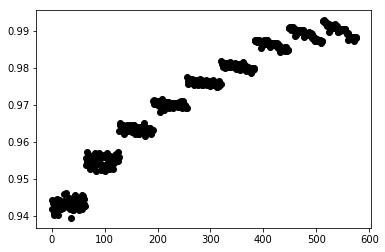

In [25]:
x = range(len(param_combo_list))

plt.plot(x, hyperparam_results['internal_grid_search_scores'], 'o', color='black');

In [33]:
# Seems the best results happen with the deepest max_depth
#If you have more time, you can run a more refined grid search closer to the 'later' combo of params

## <a id = 5> Test Performance

### <a id='51'>Data Prepping</a> 

In [27]:
from imblearn.combine import SMOTEENN

# Upsample the train fold only before passing it on 
X_resampled_train, y_resampled_train = SMOTEENN(sampling_strategy = 
                                                'all', random_state=42).fit_sample(X_train, y_train)
print(X_resampled_train.shape,sum(y_resampled_train))

(169235, 12) 94496.0


### <a id='52'>Modelling Workflow </a> 

Lets use the best params found in the previous analysis

In [28]:
classifier = RandomForestClassifier(**hyperparam_results['best_params'], 
                                    n_jobs = -1, random_state=42)
# classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Has a Train accuracy of 97.0 % 
              precision    recall  f1-score   support

 No Distress       0.95      0.98      0.97     74739
    Distress       0.99      0.96      0.97     94496

    accuracy                           0.97    169235
   macro avg       0.97      0.97      0.97    169235
weighted avg       0.97      0.97      0.97    169235

The ROC AUC Score on Train set is 1.0
Confusion matrix, without normalization
[[73506  1233]
 [ 3901 90595]]


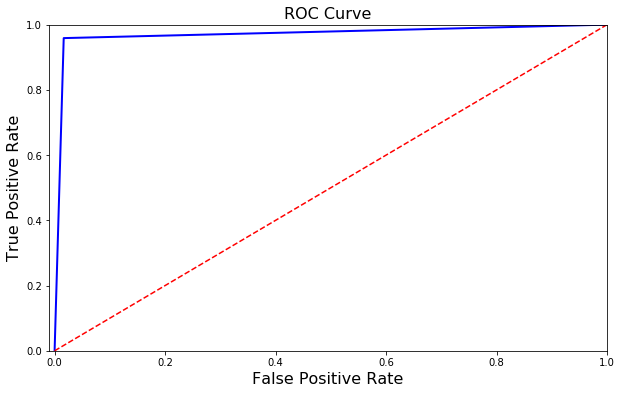

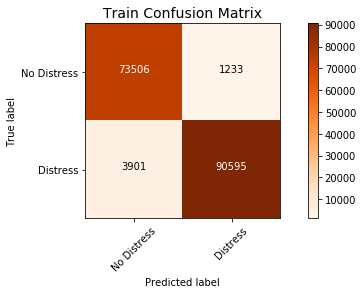

In [29]:
from helper_functions_comprehensive import custom_classification_metrics_function
custom_classification_metrics_function(X_resampled_train, y_resampled_train, labels, classifier, data_type='Train')

Has a Test accuracy of 92.0 % 
              precision    recall  f1-score   support

 No Distress       0.96      0.95      0.95     27995
    Distress       0.39      0.46      0.43      2005

    accuracy                           0.92     30000
   macro avg       0.68      0.71      0.69     30000
weighted avg       0.92      0.92      0.92     30000

The ROC AUC Score on Test set is 0.86
Confusion matrix, without normalization
[[26554  1441]
 [ 1075   930]]


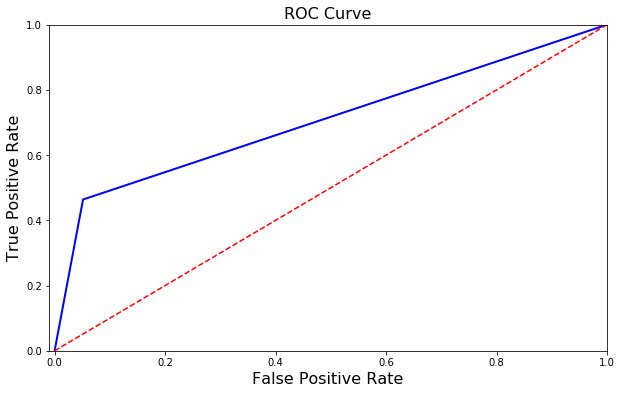

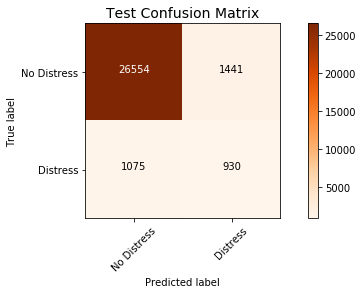

In [30]:
custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [31]:
from helper_functions_comprehensive import precision_at_recall_threshold_function

predicted_proba = classifier.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(
    y_test, predicted_proba, recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.16692774623066378


## <a id=6 >Export Data, Pickled Model and Tuned Params

In [32]:
import pickle
 
# Dump the tuned params 
pickle.dump(hyperparam_results['best_params'], 
            open(tuned_model_params_name + export_date + '.pkl', 'wb'))

# Dump the tuned model
pickle.dump(classifier, open(tuned_model_name + export_date + '.pkl', 'wb'))

## <a id=7 > References

Scoring Functions
https://stackoverflow.com/questions/32889929/gridsearchcv-scoring-parameter-using-scoring-f1-or-scoring-none-by-default-u

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://www.kaggle.com/c/expedia-hotel-recommendations/discussion/21154

F1 score vs ROC AUC
https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score

https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio#34698935

https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc
